In [10]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot
import numpy as np
import matplotlib.pyplot as plt
from ML_components import load_params
from Network import NeuralNetwork
import scipy
from scipy.signal import TransferFunction, bode, filtfilt, lfilter
import torch
from filters import butter_lowpass, ideal_lowpass
from ML_components import network_receiver
from commpy import rcosfilter, rrcosfilter
print('Yo, welcome to Main CS')

Yo, welcome to Main CS


## Automatic Tests

In [26]:
#symbol_set = [7, 5, 3, 1, -1, -3, -5, -7] # all symbols that we use
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 10

# can never not normalize and not use gain. Either one or both.
decisions = CS.transmission(SNRdb=SNR, mode='euclidean', v=True)

print("Accuracy:", 1 - CS.evaluate(decisions)[1])

1.9990983598258891
Accuracy: 0.88202


### This is interesting. It clearly shows that the lowpass filter removes a lot of bandwidth at cutoff=0.5 - so much so that it doesn't work. At 0.55 it removes some, but it still works. Which actually proves that we've band-limited the signal even more, but still have same performance, which is a significant discovery. Same performance, lower bandwidth. At 0.675, there is no difference.

In [10]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
symbol_seq = np.random.choice(symbol_set, 10000, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 10

In [11]:
def lowpass_effect(CS, cutoff=0.5, filter_type='Ideal', num_symbols=1000, time=False):

    #symbol_set = [3, 1, -1, -3] # all symbols that we use
    #symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    #m = 8
    #CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
    #SNR = 10
    
    up = CS.upsample()
    Tx = np.convolve(up, CS.h)

    if filter_type == 'Butter':
        b, a = butter_lowpass(cutoff, CS.m, 10)
        Tx_low = filtfilt(b, a, Tx)
        if time:
            plot_time(Tx, Tx_low, filter_type, cutoff)
        plot_freq(Tx, Tx_low, filter_type, cutoff)
    elif filter_type == 'Ideal':
        Tx_low = ideal_lowpass(Tx, cutoff, CS.m)
        if time:
            plot_time(Tx, Tx_low, filter_type, cutoff)
        plot_freq(Tx, Tx_low, filter_type, cutoff)
    elif filter_type == 'Both':
        b, a = butter_lowpass(cutoff, CS.m, 10)
        Tx_low = ideal_lowpass(Tx, cutoff, CS.m)
        Tx_low2 = filtfilt(b, a, Tx)
        if time:
            plot_time(Tx, Tx_low, 'Ideal', cutoff)
            plot_time(Tx, Tx_low2, 'Butter', cutoff)
        plot_freq(Tx, Tx_low, 'Ideal', cutoff)
        plot_freq(Tx, Tx_low2, 'Butter', cutoff)
        

def plot_time(Tx, Tx_low, filter_type, cutoff):
    
    plt.figure(figsize=(13,8))
    plt.title('Time Domain: ' + str(filter_type) + ' w/ Cutoff = ' + str(cutoff), fontsize=20)
    plt.plot(Tx, label='Before Lowpass')
    plt.plot(Tx_low, label='After Lowpass')
    plt.xlabel('Time', fontsize=18)
    plt.ylabel('Amplitude', fontsize=18)
    plt.grid(True)
    plt.legend(fontsize=14)
    plt.show()
    #plt.savefig('Ideal0675Time', bbox_inches='tight', transparent=True)
    
    
def plot_freq(Tx, Tx_low, filter_type, cutoff):

    plt.figure(figsize=(13,8))
    plt.title('Frequency Domain: ' + str(filter_type) + ' w/ Cutoff = ' + str(cutoff), fontsize=20)
    plt.magnitude_spectrum(Tx, sides='twosided', scale='dB', Fs=8, label='Before Lowpass')
    plt.magnitude_spectrum(Tx_low, sides='twosided', scale='dB', Fs=8, label='After Lowpass')
    plt.legend(fontsize=14)
    plt.xlabel('Magnitude (dB)', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.ylim([-60, 0])
    plt.grid(True)
    #plt.show()
    #plt.savefig('Ideal0675Freq', bbox_inches='tight', transparent=True)

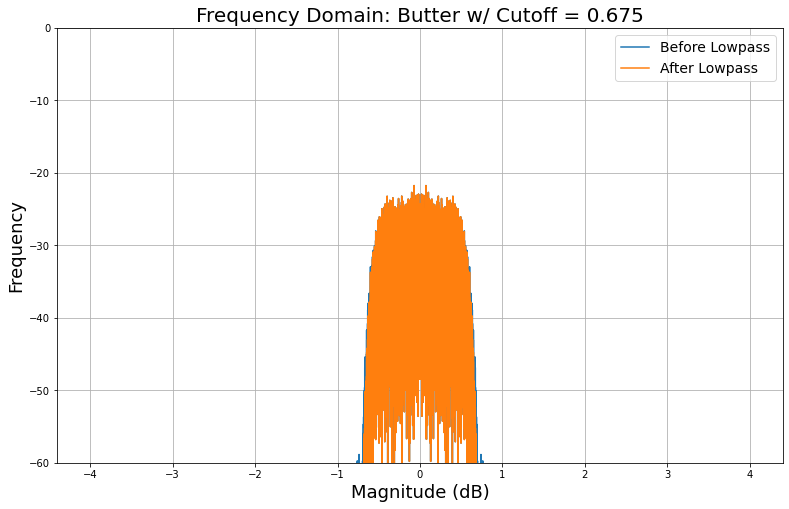

In [15]:
lowpass_effect(CS, filter_type='Butter', cutoff=0.675, time=False)
#lowpass_effect(filter_type='Butter', cutoff=0.675)

### Manual Test

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
sigma = 2

# calibrate
gain_factor = np.max(np.convolve(CS.h, CS.h))

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample()
Tx = np.convolve(upsampled, CS.h)

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)#/np.sqrt(gain_factor)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)/gain_factor

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

print(1 - CS.evaluate(decisions)[1])

### Manual Test with normalization of signal instead of gain_factor

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10

symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
symbol_seq_power = np.mean(np.square(symbol_seq))
SNR = 10
sigma = CS.SNRdb_to_sigma(SNR, 8, use_gain=False)
print('sigma:', sigma)

# upsample symbol sequence and filter it on transmission side
upsampled = CS.upsample(v=False)
Tx = np.convolve(upsampled, CS.h)

# Normalize signal with RMS
Tx = Tx / np.sqrt(np.mean(np.square(Tx)))

# Transmit the filtered signal (i.e. add noise)
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
plt.title('received')
plt.plot(Tx)
plt.show()
network_decisions = network_receiver(Tx, classes=symbol_set)
ml_filtered = np.convolve(lf_DE, Tx) # change if you use bad
plt.title('filtered with learned filter')
plt.plot(ml_filtered)
plt.show()

# Filter on receiver side
Rx = np.convolve(Tx, CS.h)
plt.title('filtered with RRC')
plt.plot(Rx)
plt.show()

# Normalize received signal with RMS * squareroot of symbol seq power?
Rx = (Rx / np.sqrt(np.mean(np.square(Rx)))) * np.sqrt(symbol_seq_power)

# Downsample the signal on the receiver side
downsampled = CS.downsample(Rx)

# Decision-making using new_values
decisions = CS.decision_making(downsampled, False)

print(1 - CS.evaluate(decisions)[1])
print(1 - CS.evaluate(network_decisions)[1])

## Display filters in various ways

In [ ]:
m = 8
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    #h = rrcosfilter(N=8 * m, alpha=beta, Ts=1, Fs=m)[1]
    #f = np.fft.fft(CS.h)
    plt.plot(CS.h)
    
x_axis = [x for x in range(len(CS.h)) if x % 8 == 0]
x_labels = [str(i)+' T' for i,x in enumerate(x_axis)]
plt.xticks(ticks=x_axis, labels=x_labels)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
raised = np.convolve(CS.h, CS.h)
#raised = rcosfilter(N=127, alpha=0.35, Ts=1, Fs=m)[1]
plt.stem(raised)
x_axis = [x for x in range(len(raised)) if x % 8 == 0]
x_labels = [str(i)+' T' for i,x in enumerate(x_axis)]
plt.xticks(ticks=x_axis, labels=x_labels)
plt.grid(True)
plt.show()


m = 8
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Raised Cosine', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    raised = rcosfilter(N=8 * m, alpha=beta, Ts=1, Fs=m)[1]
    #f = np.fft.fft(CS.h)
    plt.plot(raised)
    
x_axis = [x for x in range(len(raised)) if x % 8 == 0]
x_labels = [str(i)+' T' for i,x in enumerate(x_axis)]
plt.xticks(ticks=x_axis, labels=x_labels)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()


plt.figure(figsize=(13,8))
plt.title('Root Raised Cosine (Frequency Spectrum)', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Magnitude (Energy)', fontsize=20)
for beta in betas:
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    plt.magnitude_spectrum(CS.h, CS.m, sides='twosided')
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()

plt.figure(figsize=(13,8))
plt.title('Raised Cosine (Frequency Spectrum)', fontsize=24)
plt.xlabel('Frequency', fontsize=20)
plt.ylabel('Magnitude (Energy)', fontsize=20)
#CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
#raised = np.convolve(CS.h, CS.h)
#plt.magnitude_spectrum(raised, CS.m, sides='twosided', color='C1')
raised = rcosfilter(N=8 * m, alpha=0.35, Ts=1, Fs=m)[1]
plt.magnitude_spectrum(raised, CS.m, sides='twosided', color='C1')
plt.grid(True)
plt.show()

In [ ]:
symbol_seq = np.random.choice(symbol_set, 1000, replace=True)
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=8, beta=0.35)
CS2 = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=8, beta=0.7)
raised = np.convolve(CS.h, CS2.h)
raised2 = np.convolve(CS.h, CS.h)
plt.figure(figsize=(13,8))
plt.plot(raised, label='different')
plt.plot(raised2, label='same')
plt.legend(fontsize=14)
plt.show()

In [ ]:
# NOT WORKING RIGHT. USE RCOSFILTER INSTEAD

m = 8
betas = [0, 0.35, 0.7, 1]
plt.figure(figsize=(13,8))
plt.title('Raised Cosine by double convolution of RRC', fontsize=24)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
z = np.zeros(len(CS.h))
for beta in betas:
    #CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=beta)
    h = rrcosfilter(N=8 * m, alpha=beta, Ts=1, Fs=m)[1]
    raised = np.convolve(h, h)
    #f = np.fft.fft(CS.h)
    plt.plot(raised)
plt.grid(True)
plt.legend(betas, fontsize=12)
plt.show()

____

# Evaluation of pretrained Decision Making models

In [ ]:
for i in range(5):

    symbol_set = [3, 1, -1, -3] # all symbols that we use
    num_symbols = 10000
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m)
    SNRdb = 16
    
    euclid_decs, NN_decs, block_decs, network_decs, joint_decs = CS.transmit_all(SNRdb, joint_cutoff=0.675)
    

    print('Euclidean Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('NN Error Rate: {}%'.format((CS.evaluate(euclid_decs)[1]*100).round(2)))
    print('Block Error Rate: {}%'.format((CS.evaluate(block_decs)[1]*100).round(2)))
    print('Receiver Network Error Rate: {}%'.format((CS.evaluate(network_decs)[1]*100).round(2)))
    print('Joint Sender-Receiver Network Error Rate: {}%'.format((CS.evaluate(joint_decs)[1]*100).round(2)))
    print()

### SNR Calculations

In [ ]:
RX_net_BP = torch.load('../Conv1DModels/RX_Network2')
RX_net_DE = torch.load('../Conv1DModels/Best_DE_Model2')

In [ ]:
SNRdbs, euclid_error_rates, network_error_rates_BP, NN_error_rates, block_error_rates, \
joint_error_rates, error_theory = SNR_plot(num_symbols=30000, rx_model=RX_net_BP, range=[-30, 0])

In [ ]:
lf = list(RX_net_DE.parameters())[0].detach()[0][0]
plt.plot(lf)

In [ ]:
plt.figure(figsize=(13,8))
#plt.title('Joint Networks Noise Plot with cutoff  ' r'$\frac{1}{2}$', fontsize=24)
#plt.title('Noise Plot')
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=24)
num = 0
plt.semilogy(SNRdbs[num:], euclid_error_rates[num:], alpha=1, linewidth=3, label='Euclidean')
#plt.semilogy(SNRdbs[num:], NN_error_rates[num:], label='NN Dec Maker')
#plt.semilogy(SNRdbs[num:], block_error_rates[num:], label='Block')
plt.semilogy(SNRdbs[num:], network_error_rates_BP[num:], alpha=1, linewidth=3, label='Receiver Network (BP)')
plt.semilogy(SNRdbs[num:], network_error_rates_DE[num:], alpha=0.75, linewidth=3, label='Receiver Network (DE)')
#plt.semilogy(SNRdbs[num:], joint_error_rates[num:], alpha=1, linewidth=3, label='Joint Networks')
#plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=0.75, linewidth=3, label='Theory')
plt.legend(fontsize=16)
plt.show()
#plt.savefig('RX_BP_and_DE2', bbox_inches='tight', transparent=True)

In [ ]:
er_for_sigma3 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(3**2))))
er_for_sigma2 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(2**2))))
er_for_sigma1 = 1.5 * (1 - scipy.stats.norm.cdf(np.sqrt(8/(1**2))))
print(1-er_for_sigma1, 1-er_for_sigma2, 1-er_for_sigma3)

# Inspect Decision Boundaries for NN Decision Making

## Plot 1

In [ ]:
weights, biases, sizes = load_params('../Weights/decision_making_weights.npz',
                                         '../Weights/decision_making_biases.npz')
NN = NeuralNetwork(sizes, startweights=weights, startbiases=biases,
                           type='classification', afunc='relu')
classes = np.array(symbol_set)

test_seq = np.linspace(-4, 4, 40)
test_seq = np.array(test_seq, ndmin=2).T
yhat_onehot = NN.feedforward(test_seq)
print(yhat_onehot.shape)


plt.figure(figsize=(13,8))
#plt.title('Decision Boundaries', fontsize=24)
for i in range(yhat_onehot.shape[1]):
    plt.plot(test_seq, yhat_onehot[:,i], '-x')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
plt.xlabel('Input', fontsize=20)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + ['Euclidean Boundaries'], fontsize=14)
plt.show()
#plt.savefig('Boundaries', bbox_inches='tight', transparent=True)

## Plot 2

In [ ]:
classes = np.array(symbol_set)
test_seq = np.linspace(-4, 4+1, 100)
test_seq = np.array(test_seq, ndmin=2).T

yhat_idx = NN.feedforward(test_seq).argmax(axis=1)
yhat = classes[yhat_idx]
euclid_decisions = CS.decision_making(test_seq)


num = len(test_seq)
plt.figure(figsize=(13,8))
plt.xlabel('Sample Value (input)', fontsize=20)
plt.ylabel('Decided value (output)', fontsize=20)
plt.plot(test_seq[:num], euclid_decisions[:num], '-bx', alpha=1, label='Euclidean')
plt.plot(test_seq[:num], yhat[:num], '-rx', alpha=1, label='Neural Network')
plt.legend(fontsize=14)
plt.show()

# Inspect Decision Boundaries for RX_Network (How should this be interpreted??)

In [ ]:
test_seq = np.random.choice(symbol_set, 10000, replace=True)
CS = Comms_System(symbol_set=symbol_set, symbol_seq=test_seq, num_samples=8, beta=0.35)
classes = np.array(symbol_set)

upsampled = CS.upsample()
Tx = np.convolve(upsampled, CS.h)
#test_seq = np.sort(Tx)
#Tx = Tx + np.random.normal(0.0, , Tx.shape)  # add gaussian noise


net = torch.load('../Conv1DModels/RX_Network2')
net2 = torch.load('../Conv1DModels/Best_DE_Model2')
test_seq = np.linspace(-4, 4, 400)
test_seq = torch.Tensor(test_seq)
x = test_seq.view(1, 1, -1)
print(x.shape)
yhat = net(x)[0].T
yhat2 = net2(x)[0].T
softmax = torch.nn.Softmax(dim=1)
probs = softmax(yhat).detach().numpy()
probs2 = softmax(yhat2).detach().numpy()
decisions = classes[np.argmax(probs, axis=1)]
decisions2 = classes[np.argmax(probs2, axis=1)]


plt.figure(figsize=(13,8))
#plt.title('Decision Boundaries', fontsize=24)
for i in range(probs.shape[1]):
    plt.plot(probs[:,i], '-x')
for i in range(probs2.shape[1]):
    plt.plot(probs2[:,i], '-o')
#plt.axvline(x=-2, color='black')
#plt.axvline(x=0, color='black')
#plt.axvline(x=2, color='black')
#plt.xlabel('Input', fontsize=20)
x_axis = range(len(decisions))
x_labels = ['Vector'+str(i) for i in range(len(x_axis))]
plt.xticks(ticks=x_axis, labels=x_labels, rotation=60)
plt.ylabel('Probability of choosing', fontsize=20)
plt.legend(symbol_set + symbol_set, fontsize=14)
plt.show()

print(test_seq.reshape(-1, 8))
print(decisions)

# Inspect effect of filtering with learned filters versus with RRC

In [ ]:
net_BP = torch.load('../Conv1DModels/RX_Network2')
net_DE = torch.load('../Conv1DModels/Best_DE_Model2')
#net_DE = torch.load('../Conv1DModels/LF_DE_100kSNR6.5_2', map_location=torch.device('cpu'))


lf_BP = list(net_BP.parameters())[0].detach()[0][0].numpy()
lf_BP /= np.sqrt(np.sum(np.square(lf_BP)))

lf_DE = list(net_DE.parameters())[0].detach()[0][0].numpy()
lf_DE /= np.sqrt(np.sum(np.square(lf_DE)))

h = CS.h/np.sqrt(np.sum(np.square(CS.h)))

plt.figure(figsize=(13,8))
plt.plot(lf_BP, label='Learned Filter (BP)', linewidth=3, color='C1')
plt.plot(lf_DE, label='Learned Filter (DE)', linewidth=3, color='C2')
plt.plot(h, label='Root-Raised Cosine', alpha=.8, linewidth=3, color='C0')
plt.legend(fontsize=14)
plt.grid(True)
plt.show()
#plt.savefig('LF_ALL', bbox_inches='tight', transparent=True)

In [ ]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
SNR = 10
sigma = CS.SNRdb_to_sigma(SNRdb=SNR, energy=8, use_gain=False)
print(sigma)

up = CS.upsample()
Tx = np.convolve(up, h)
Tx = Tx / np.sqrt(np.mean(np.square(Tx)))
Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise

# Filter on receiver side with learned filter
Rx1 = np.convolve(Tx, h)
#Rx1 /= np.sqrt(np.mean(np.square(Rx1)))
plt.plot(Rx1, label='Filt w/ RRC')
Rx2 = np.convolve(Tx, lf_BP)
#Rx2 /= np.sqrt(np.mean(np.square(Rx2)))
plt.plot(Rx2, label='Filt w/ lf_BP')
Rx3 = np.convolve(Tx, lf_DE)
#Rx3 /= np.sqrt(np.mean(np.square(Rx3)))
plt.plot(Rx3, label='Filt w/ lf_DE')
plt.legend()
plt.show()

# Plot full responses 

In [ ]:
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)
#raised_cosine = np.convolve(CS.h, CS.h)
raised_cosine = rcosfilter(N=127, alpha=0.35, Ts=1, Fs=m)[1]
full_response_BP = np.convolve(CS.h, lf_BP)
full_response_DE = np.convolve(CS.h, lf_DE)
raised_cosine /= np.sqrt(np.sum(np.square(raised_cosine)))
full_response_BP /= np.sqrt(np.sum(np.square(full_response_BP)))
full_response_DE /= np.sqrt(np.sum(np.square(full_response_DE)))
x_axis = [x for x in range(len(raised_cosine)) if x % 8 == 0]
x_labels = [str(i)+' T' for i,x in enumerate(x_axis)]


plt.figure(figsize=(13,8))
plt.plot(raised_cosine, label='Raised Cosine Impulse Response', linewidth=3)
plt.plot(full_response_BP, label='Full System Response (BP)', linewidth=3)
plt.plot(full_response_DE, label='Full System Response (DE)', linewidth=3, alpha=.8, color='C2')
#for i in range(0, 128, 4):
 #   plt.axvline(x=i, color='black', alpha=0.5)
plt.xticks(ticks=x_axis, labels=x_labels)
plt.legend(fontsize=14)
plt.grid(True)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Amplitude', fontsize=16)
plt.show()
#plt.savefig('FullResponsesAll', bbox_inches='tight', transparent=True)

# Plot Lowpass Filters

In [ ]:
# Butterworth

cutoff = 0.5
b_10, a_10 = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=10)
#b_4, a_4 = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=4)
w_range = np.linspace(-4, 4, 10000)
w_10, m_10, _ = TransferFunction(b_10, a_10/7.3, dt=CS.m).bode(n=10000, w=w_range)
#w_10, m_10, _ = TransferFunction(b_10, a_10, dt=CS.m).bode(n=10000, w=w_range)
#w_4, m_4, _ = TransferFunction(b_4, a_4, dt=CS.m).bode(n=10000, w=w_range)


# Raised Cosine
h = CS.h / max(CS.h)
#raised_cosine = rcosfilter(N=8*m, alpha=0.35, Ts=1, Fs=8)[1]
raised_cosine = np.convolve(CS.h, CS.h)
raised_cosine /= max(raised_cosine)

w_raised, m_raised, _ = TransferFunction(raised_cosine, 1, dt=CS.m).bode(n=10000, w=w_range) #65

# Root-Raised Cosine
w_rrc, m_rrc, _ = TransferFunction(h, 1, dt=CS.m).bode(n=10000, w=w_range) # 8

# Ideal Lowpass Filter
w10 = w_10*10
idx1 = np.where(w10.round(3) == -cutoff)[0][0]
idx2 = np.where(w10.round(3) == cutoff)[0][0]
ideal = np.ones(len(w10)) * -70
ideal[idx1: idx2+1] = 17.34 # 0

plt.figure(figsize=(13,8))
plt.plot(w10, ideal, linewidth=3, color='C2', label='Ideal Lowpass Filter') # ideal
#plt.plot(w_4*10, m_4, linewidth=3, color='C4', alpha=0.5, label='Butterworth (order=4)') # butterworth order 4
plt.plot(w_10*10, m_10, linewidth=3, color='C0', label='Butterworth (order=10)') # butterworth order 10
plt.plot(w_rrc*10, m_rrc, linewidth=3, color='C1', label='RRC (rolloff=0.35)') # rrc
plt.plot(w_raised*10, m_raised, linewidth=3, color='C5', label='Raised Cosine (rolloff=0.35)')
plt.title('Filters Frequency Response (cutoff = '+str(cutoff)+'Hz)', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Magnitude [dB]', fontsize=16)
plt.legend(fontsize=12, loc='upper right')
plt.grid(True)
#plt.yticks(np.arange(-20, 20, 1))
plt.ylim([-20, 20])
plt.xlim([-1.5, 1.5])
plt.show()

/Users/Dragonborn/anaconda/lib/python3.6/site-packages/scipy/signal/filter_design.py:1626: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  "results may be meaningless", BadCoefficients)


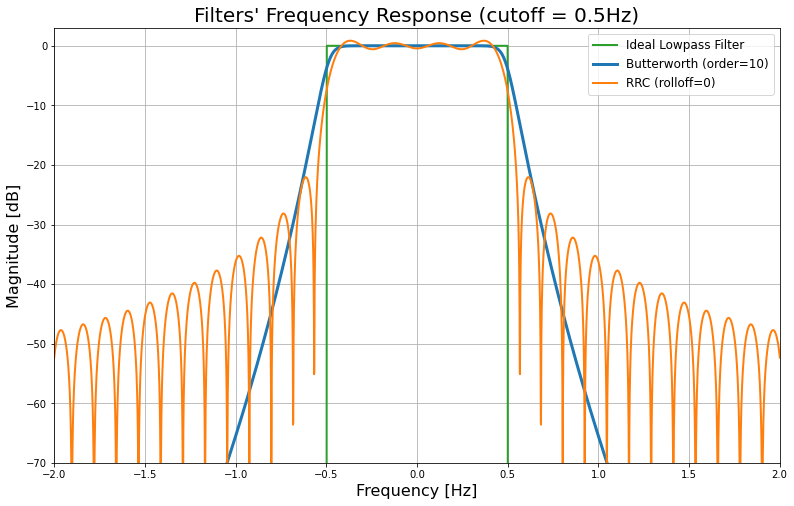

In [9]:
# Butterworth
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=8, beta=0)
cutoff = 0.5
b, a = butter_lowpass(cutoff_freq=cutoff, sampling_rate=CS.m, order=10)
b2, a2 = butter_lowpass(cutoff_freq=0.5, sampling_rate=CS.m, order=10)
w_range = np.linspace(-4, 4, 10000)
w, m, _ = TransferFunction(b, a, dt=CS.m).bode(n=10000, w=w_range)
w2, m2, _ = TransferFunction(b2, a2, dt=CS.m).bode(n=10000, w=w_range)


# Root-Raised Cosine
h = CS.h / max(CS.h)
w_rrc, m_rrc, _ = TransferFunction(CS.h, 8, dt=CS.m).bode(n=10000, w=w_range) # 8

# Ideal Lowpass Filter
w10 = w*10
idx1 = np.where(w10.round(3) == -cutoff)[0][0]
idx2 = np.where(w10.round(3) == cutoff)[0][0]

ideal = np.ones(len(w10)) * -80
ideal[idx1+2: idx2+1] = 0


plt.figure(figsize=(13,8))
plt.plot(w10, ideal, linewidth=2, color='C2', label='Ideal Lowpass Filter ') # ideal
plt.plot(w*10, m, linewidth=3, color='C0', label='Butterworth (order=10)') # butterworth order 10
#plt.plot(w2*10, m2, linewidth=2, color='C3', label='Butterworth (order=10) (cutoff=0.5)') # butterworth order 10
plt.plot(w_rrc*10, m_rrc, linewidth=2, color='C1', label='RRC (rolloff=0)') # rrc
plt.title("Filters' Frequency Response (cutoff = "+str(cutoff)+'Hz)', fontsize=20)
plt.xlabel('Frequency [Hz]', fontsize=16)
plt.ylabel('Magnitude [dB]', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
#plt.yticks(np.arange(-40, 3, 3))
#plt.xticks(np.arange(-1, 1, 0.1))
#plt.axhline(y=-3, color='black')
plt.ylim([-70, 3])
plt.xlim([-2, 2])
plt.show()
#plt.savefig('Filters055', bbox_inches='tight', transparent=True)

##### Want to time something? Use following code stump

In [ ]:
# %%timeit -o -r 5